## SVC Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle

In [24]:
df = pd.read_csv("dataset.csv")
len(df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17808

In [25]:
df['severity'].value_counts()

medium          5594
small           2612
unknown          834
large            679
...              359
very_large       102
Medium            72
Unknown           19
Large             17
Small             10
catastrophic       4
landslide          2
Very...large       1
Very_large         1
Name: severity, dtype: int64

In [26]:
df.landslide.value_counts()

1    10306
0     7502
Name: landslide, dtype: int64

In [27]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))

17808


In [34]:
import random
X = []
y = []
days = dict()
mac = 2577
for idx, row in df.iterrows():
    lastday = random.randint(6, 9)
    if row.landslide == 1:
        y.append(lastday-4)
    else:
        mac -= 1
        if mac<=0:
            continue
        y.append(-1)
    temp=[]
    if lastday in days:
        days[lastday] +=1
    else:
        days[lastday] = 0
    for i in range(5):
        temp.append(row['humidity' + str(lastday-i)])
        temp.append(row['ARI' + str(lastday-i)])
        temp.append(row['wind' + str(lastday-i)])
    temp.append(row['slope'])
    year = int(str(row.date)[-2:])
    temp.append(row['forest2'])
#     temp.append(1 if year - row.forest_year <= 2 else 0)
    temp.append(row['osm'])
    X.append(temp)
    if idx == 0:
        print(year, row.forest_year)
print(days)

11 10
{9: 3299, 7: 3198, 8: 3170, 6: 3211}


## Scaling

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [36]:
from sklearn.decomposition import PCA
pca = PCA(0.95)

principalComponents = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.33909101, 0.17054503, 0.13600395, 0.0585007 , 0.05547552,
       0.04499722, 0.03979274, 0.02903705, 0.02536788, 0.0182876 ,
       0.01709012, 0.01482805, 0.01416886])

In [37]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [38]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', verbose = True)

In [39]:
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(verbose=True)

In [40]:
from sklearn.metrics import accuracy_score
pred = svclassifier.predict(X_test)
print("ACCURACY:", accuracy_score(pred, y_test))

ACCURACY: 0.3476911136980986


## Testing gamma and c

In [41]:
from sklearn.metrics import accuracy_score
C_range =[1, 10, 100]
gamma_range = [0.1, 1, 10, 100]
for c in C_range:
    for g in gamma_range:
        svc2 = SVC(kernel='rbf', gamma=g,C=c, verbose = True)
        svc2.fit(X_train, y_train)
        print(c, g, ":",accuracy_score(y_test, svc2.predict(X_test)))

[LibSVM]1 0.1 : 0.35079549864183157
[LibSVM]1 1 : 0.35001940240589835
[LibSVM]1 10 : 0.25533566162204113
[LibSVM]1 100 : 0.21420256111757857
[LibSVM]10 0.1 : 0.3585564610011641
[LibSVM]10 1 : 0.3473030655801319
[LibSVM]10 10 : 0.2576639503298409
[LibSVM]10 100 : 0.21497865735351185
[LibSVM]100 0.1 : 0.3585564610011641
[LibSVM]100 1 : 0.3414823438106325
[LibSVM]100 10 : 0.2572759022118743
[LibSVM]100 100 : 0.21497865735351185


In [14]:
svc2 = SVC(kernel='rbf', gamma=0.1,C=10, verbose = True)
svc2.fit(X_train, y_train)
accuracy_score(y_test, svc2.predict(X_test))

[LibSVM]

0.5162829870859068

In [15]:
pred = svc2.predict(X_test)
print("ACCURACY:" ,accuracy_score(pred, y_test))

ACCURACY: 0.5162829870859068


## Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, pred)
array

array([[1388,   36,   36,   25,   30],
       [ 115,  128,   80,   87,  119],
       [ 131,   88,   90,   86,   93],
       [ 127,   91,   96,   95,  110],
       [ 142,   85,   69,   77,  138]])

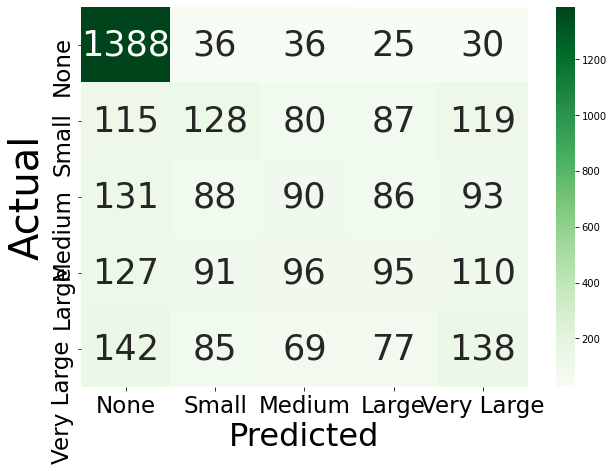

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
binary=False
if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Greens", annot=True, annot_kws={"size":35}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=23)
plt.xlabel('Predicted', fontsize = 32) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40) 
# plt.savefig("SVC Matrix", bbox_inches="tight")

plt.show()